In [40]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

import boda
from boda.generator.parameters import BasicParameters
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
test_path = 'gs://syrgoth/boda_library_design_202112/pickles/sg__hepg2__fsp__track_001__round_5__20211207_194303__533151.pt'
model_paths = [
    'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
    'gs://syrgoth/aip_ui_test/model_artifacts__20211112_154705__841131.tar.gz',
    'gs://syrgoth/aip_ui_test/model_artifacts__20211113_205602__613479.tar.gz'
]

model_paths = ['gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211119_011437__338420.tar.gz']

In [7]:
all_pickle_paths = !gsutil ls $'gs://syrgoth/boda_library_design_202112/pickles'

In [9]:
all_pickle_paths = [ path for path in all_pickle_paths if 'sg__' in path ]

In [3]:
def load_stash(filepath):
    if 'gs://' == filepath[:5]:
        with tempfile.TemporaryDirectory() as tmpdir:
            temp_loc = os.path.join( tmpdir, os.path.basename(filepath) )
            subprocess.check_call(
                ['gsutil', 'cp', filepath, temp_loc]
            )
            stash = torch.load(temp_loc)
    else:
        stash = torch.load(filepath)
    return stash

In [16]:
left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)


def run_model(model, x):
    with torch.no_grad():
        bsz = x.shape[0]
        expander = [bsz, -1, -1]
        passthrough = BasicParameters(
            torch.randn_like(x), 
            left_flank = left_flank.expand(*expander), 
            right_flank = right_flank.expand(*expander)
        )
        passthrough.to(model.device)

        return model( passthrough(x.to(model.device)) ).cpu()

def load_stash_to_df(filepath, *model_paths, round_override=False):
    models = []
    if len(model_paths) > 0:
        print(f'loading {len(model_paths)} model(s)')
        for i, model_path in enumerate(model_paths):
            with tempfile.TemporaryDirectory() as tmpdirname:
                unpack_artifact(model_path, tmpdirname)
                _hold = model_fn(os.path.join(tmpdirname,'artifacts'))
                _hold.cuda()
                _hold.eval()
                models.append( _hold )            
    
    user, cell, gen, track_id, round_id, date_time, rand_id = os.path.basename(filepath).split('__')
    track_id = int(track_id.split('_')[1])
    date, time = [int(x) for x in date_time.split('_')]
    round_id = int(round_id.split('_')[1])
    rand_id = int(rand_id.split('.')[0])
    
    stash = load_stash(filepath)
    
    seq_list = []
    round_list = []
    
    model_results = { i: [] for i in range(len(models)) }
    
    for idx, proposal_round in enumerate(stash['proposals']):
        tensors = proposal_round['proposals']
        
        for j, model in enumerate(models):
            model_results[j].append( run_model(model, tensors) )
        
        seqs = list( utils.batch2list(tensors) )
        
        seq_list += seqs
        if round_override:
            round_list += [round_id] * len(seqs)
        else:
            round_list += [idx] * len(seqs)
        
    line_count = len(seq_list)
    
    data_dict =  {
        'sequence': seq_list,
        'penalty_round': round_list,
        'user': [ user ] * line_count,
        'generator':[ gen ] * line_count,
        'cell':[ cell ] * line_count,
        'track':[ track_id ] * line_count,
        'date':[ date ] * line_count,
        'time':[ time ] * line_count,
        'random_tag':[ rand_id ] * line_count,
    }

    relist_preds = []
    for i in range(len(models)):
        pred_set = model_results[i]
        cat_preds= torch.cat(pred_set, dim=0)
        n_preds, n_feats = cat_preds.shape
        relist_preds.append(cat_preds)
    avg_pred = torch.stack(relist_preds, dim=0).mean(0)
    for j in range(n_feats):
        data_dict[f'preds_cell_{j}'] = avg_pred[:,j].numpy()
    
    data = pd.DataFrame( data_dict )
    
    return data

In [44]:
def read_fasta(file_obj):
    fasta_tags = []
    fasta_seqs = []
    
    for i, line in enumerate(file_obj.readlines()):
        if i % 2 == 0:
            fasta_tags.append(line.rstrip())
        else:
            fasta_seqs.append(line.rstrip().upper())
            
    return fasta_tags, fasta_seqs
    

def load_fasta(filepath):
    
    if 'gs://' == filepath[:5]:
        with tempfile.TemporaryDirectory() as tmpdir:
            temp_loc = os.path.join( tmpdir, os.path.basename(filepath) )
            subprocess.check_call(
                ['gsutil', 'cp', filepath, temp_loc]
            )
            with open(temp_loc, 'r') as f:
                stash = read_fasta(f)
    else:
        with open(filepath, 'w') as f:
            stash = read_fasta(f)
    return stash

def fasta_to_dataframes(filepath, *model_paths, cell_idx=0):
    models = []
    if len(model_paths) > 0:
        print(f'loading {len(model_paths)} model(s)')
        for i, model_path in enumerate(model_paths):
            with tempfile.TemporaryDirectory() as tmpdirname:
                unpack_artifact(model_path, tmpdirname)
                _hold = model_fn(os.path.join(tmpdirname,'artifacts'))
                _hold.cuda()
                _hold.eval()
                models.append( _hold )            
    
    model_results = { i: [] for i in range(len(models)) }

    fasta_tags, fasta_seqs = load_fasta(filepath)
    line_count = len(fasta_seqs)

    data_dict =  {
        'sequence': fasta_seqs,
        'penalty_round': [0] * line_count,
        'user': [ 'sr' ] * line_count,
        'generator':[ 'dhs' ] * line_count,
        'cell':[ cell_idx ] * line_count,
        'track':[ 0 ] * line_count,
        'date':[ 20211207 ] * line_count,
        'time':[ 122030 ] * line_count,
        'random_tag':[ 999999 ] * line_count,
    }
    
    onehot_sequences = torch.stack(
        [utils.dna2tensor(subsequence) for subsequence in tqdm(fasta_seqs)]
    )
    
    for j, model in enumerate(models):
        model_results[j].append( run_model(model, onehot_sequences) )
     
    relist_preds = []
    for i in range(len(models)):
        pred_set = model_results[i]
        cat_preds= torch.cat(pred_set, dim=0)
        n_preds, n_feats = cat_preds.shape
        relist_preds.append(cat_preds)
    avg_pred = torch.stack(relist_preds, dim=0).mean(0)
    for j in range(n_feats):
        data_dict[f'preds_cell_{j}'] = avg_pred[:,j].numpy()    
    
    data = pd.DataFrame( data_dict )
    
    return data

In [5]:
my_data = load_stash_to_df(test_path, *model_paths)

loading 3 model(s)


archive unpacked in /tmp/tmpugtzdzt0


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpz1l86koe


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpk9ozuxu_


Loaded model from 20211119_011437 in eval mode


In [6]:
my_data

,sequence,penalty_round,user,generator,cell,track,date,time,random_tag,preds_cell_0,preds_cell_1,preds_cell_2
0,GATCTTGGACAGTGTTCAGAGCGCAGTAGTTATCCCGCTCTCCGAA...,0,sg,fsp,hepg2,1,20211207,194303,533151,-0.215762,6.250153,-0.540798
1,GGTGCAATTCCGTCGGGGGCCGTCGTGAGAATAGCTTGTATGCGGG...,0,sg,fsp,hepg2,1,20211207,194303,533151,-0.323467,6.939346,-0.773942
2,CTTCCCAAAGGCGTGAAGCAAGTGCATTGATTTAGGGTTGACGCAT...,0,sg,fsp,hepg2,1,20211207,194303,533151,-0.488120,4.720260,-0.777049
3,GGGTGCCCGCTGACCTGGTTAATGATTAACCAGGGGATTCTCAGCA...,0,sg,fsp,hepg2,1,20211207,194303,533151,-0.344566,11.012416,-0.617590
4,GGCTGGTTAATCATTAACCAGAAGACTCGCGCAACGGTCCAAAGTC...,0,sg,fsp,hepg2,1,20211207,194303,533151,-0.398559,8.773662,-0.538248
...,...,...,...,...,...,...,...,...,...,...,...,...
4495,CAATCCCAAACATTAGTGATATGGCTCAGGTAGGTGACAGGAATAT...,5,sg,fsp,hepg2,1,20211207,194303,533151,0.834062,4.443956,0.797322
4496,TGCTAGCGCGGTTGAAAGATTGTAACCCAGATTTTCATGTTGGTGC...,5,sg,fsp,hepg2,1,20211207,194303,533151,0.062626,4.028974,1.139594
4497,CGTTACGACATGAACTGGCAATGCGTTTACCTCAGTAGTATAAGTT...,5,sg,fsp,hepg2,1,20211207,194303,533151,0.107993,2.329361,0.771194
4498,CATTACGGGTGCCGGGAAGGTGCGTGTGAATCCAGGGCATACAGCA...,5,sg,fsp,hepg2,1,20211207,194303,533151,0.052138,1.782599,0.179298


In [10]:
all_pickle_paths = !gsutil ls $'gs://syrgoth/boda_library_design_202112/pickles'
all_pickle_paths = [ path for path in all_pickle_paths if 'sg__' in path ]

sg_data = pd.concat([ load_stash_to_df(path, *model_paths) for path in all_pickle_paths ]).reset_index(drop=True)

loading 3 model(s)


archive unpacked in /tmp/tmpjeq8wszb


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpihqvxuj_


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpg7y09msw


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp59th0o12


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp0sn1sdyx


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp2b2co6bx


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpu833rduy


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpxq6y_bnh


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp81aftmkk


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmps11qheae


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp19dgl65i


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpg5gkxxud


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpga_iloh8


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmphg1sr10r


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp0j5mfcyl


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpiui60tzv


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp40a5322g


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp2ap3a8mm


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpcfdqzxqq


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmphxmvb060


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp630gs19x


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpbuua8cha


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmppqhov1jt


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp0h43_wmt


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp95ybiwsu


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp37_ec3hk


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpdt1e9yzu


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpa6pqsr1v


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpcb_qccer


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpo2n0f8ww


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp2a_q2qo4


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp4lfehjlk


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpyshdo40z


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpj5la2uy_


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpxw1dotr0


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpgf4hqfvg


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpp9aturjo


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp6gg0o9bh


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpjwcrtt6r


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpxh8pfuh6


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp8ksmqnti


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpgbj0476z


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp0pe1z8cr


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpwvwan3gf


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp5dskgzse


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp9oz7hqcg


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpo8_cgh8_


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp00w8691o


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp9qip74g3


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpavwjd5nn


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp40spp8eh


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpyoen224x


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmplebja3u0


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpcdxd1cl0


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp5hhx8vxn


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpywzc144v


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp_fabpms_


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpfugxj76i


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp_9ogj0gj


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpo5ee23mp


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp4qoq4os0


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpzwpoba7c


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpirvitjom


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpuf3mvhex


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpwhje95eh


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpcg0km5hs


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpqvohly2e


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp6s9byapf


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpqbzet_89


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp2px_fvqa


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpj4_sj8as


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpsvehlexp


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpkpr97y8w


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmppcp9d9wy


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp35g4bzv_


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpmavs84ce


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpji3mkw_7


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpypokns4f


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmppyiprn_j


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpwzal_r2e


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpfd03tv36


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmppaeam1c4


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpiyjrwo24


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpd_wusnkm


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp26x9gtjk


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpg2hkwqhg


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp2wblph6w


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp7i57_j92


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpqqtytor0


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpmwzxb9jh


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpse73ve9j


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpt13s065_


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpfd4q9p04


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpvwn44pq7


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp4crvr40d


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmptcyx7cfi


Loaded model from 20211119_011437 in eval mode


In [28]:
sg_data

In [22]:
all_pickle_paths = !gsutil ls $'gs://syrgoth/boda_library_design_202112/pickles'
all_pickle_paths = [ path for path in all_pickle_paths if 'rc__' in path ]

rc_data = pd.concat([ load_stash_to_df(path, *model_paths, round_override=True) for path in all_pickle_paths ]).reset_index(drop=True)

loading 3 model(s)


archive unpacked in /tmp/tmp3eu3e7yw


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpkakpjruc


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpxmo7iwa_


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpe_b94d8p


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpbglsgapm


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpfl_zdxo0


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpnfu84pxe


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmprjsrth5q


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmputu5be57


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmppqnlfwoy


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmprkhqhflt


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp49k0at9t


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpd0pcmixk


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpb8g063hb


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpytb0276k


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpw7v8_p0w


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp5hcl6y37


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp15nv24d4


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpl6sct3s3


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmprv2d66sv


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmppbkxb3uv


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpt6uxcio2


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp6747v5xd


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp0n2_6r5m


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp3sppk6v5


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp7ob9fjwh


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpsjwko8jx


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpvw4tr9_i


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpz4bjuovv


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpbdkqv2d3


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpxxyr_3zj


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpclviqhvg


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmplqw6id9i


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpe7f9m85_


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpt1oh8mqq


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp71hl98k8


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp71yuqj27


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpwvq5vbtv


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpts46ls3g


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpevpc7cxo


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpu8v8m42b


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpq9erpndv


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp8babq_qz


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp684w37_a


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp7b2saqsw


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpmev943w8


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpb2r2dxc3


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpy38p6079


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp1mj_giz_


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp0q2qfsk5


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpzlbg87ao


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpsdd87gw3


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpu5_u3_id


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpecifd8d8


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpln6nj7t0


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpiktq9jfu


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpc2i_qj2i


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpj1k88j4i


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp37enfod8


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp2ul_xcqb


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmper_0uw76


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp0lhrljy1


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpecq9lqmx


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmponfm3oft


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpzyfn87nb


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp1y5c3hfd


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpd8ug1t1q


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp6_v_je46


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpjl83fuwh


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp8f4xzivw


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpdbi5d7cy


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp2f9f6d95


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpjtxw4_4s


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpkdd8_1w9


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpn9a9v_9w


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp30yusyrm


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmprhttxr6q


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp8sif8c54


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpdup6jjij


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp5slin43m


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmphmeyjz19


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpsbyaekyb


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpbukfh9sk


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpvwxa0rs0


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp90kzmqrs


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpywd_xf03


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpjmb2u93k


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp_uihwaw1


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp5dgzhbsf


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpq3enczq3


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp930_fsn5


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpzojcdi8y


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpecwii00k


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmp3yy6gf6h


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpax4np6cf


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmprsyuz211


Loaded model from 20211119_011437 in eval mode
loading 3 model(s)


archive unpacked in /tmp/tmpv1y7jfxz


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp8a_5hzdh


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpf853c8li


Loaded model from 20211119_011437 in eval mode


In [26]:
rc_data

,sequence,penalty_round,user,generator,cell,track,date,time,random_tag,preds_cell_0,preds_cell_1,preds_cell_2
0,CATCTCACCTGTAAATCTCAATCAGTGCTTCGACAGATAACGGTCA...,0,rc,al,hepg2,2,20211206,25443,72806280,-1.299868,5.195824,-1.572185
1,TTAGCTCATCCTCTCCGTAGGGCGCACCTGCACAATCTGATGCTAG...,0,rc,al,hepg2,2,20211206,25443,72806280,-1.417148,5.089907,-1.658575
2,GCTCGATGCCAACGAGCCTATGACTAACATTCGATGCATACAGGTG...,0,rc,al,hepg2,2,20211206,25443,72806280,-1.393966,4.574755,-1.673908
3,GGCGCGACTCATTGTCATTGCCCAGTGCCATTCTATGTCAATATTT...,0,rc,al,hepg2,2,20211206,25443,72806280,-0.964659,3.159708,-1.039740
4,GCTCGCGCTGCGCACCTGTGCAAACAACCTTTGCCCGCCGAAGGCT...,0,rc,al,hepg2,2,20211206,25443,72806280,-1.539611,3.938985,-1.419131
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,CCCTTGGTCCACGACGAGTCAAACCATCTTTCGGTACCCTGGCATC...,0,rc,al,sknsh,7,20211207,212124,46481152,-1.001719,-1.032117,4.660513
14996,TAGAAGGAAATTACTAAGATGCGAGTGGTACCAGAGCTAACTTAAG...,0,rc,al,sknsh,7,20211207,212124,46481152,-0.452778,-0.416581,4.058228
14997,CCTGGCACCGAGTGATGGGCATACGCTCCATCATACACGGAAGGGC...,0,rc,al,sknsh,7,20211207,212124,46481152,-1.136951,-1.119118,5.341090
14998,GCTCGAATCTGGCCCGGATGCTGATTTAAGTATGAGTCAAGGAATC...,0,rc,al,sknsh,7,20211207,212124,46481152,-0.705151,-0.815807,4.297011


In [49]:
sr_k562  = fasta_to_dataframes('gs://syrgoth/boda_library_design_202112/fastas/control_DHS_K562.fa', *model_paths, cell_idx='k562')
sr_hepg2 = fasta_to_dataframes('gs://syrgoth/boda_library_design_202112/fastas/control_DHS_HEPG2.fa', *model_paths, cell_idx='hepg2')
sr_sknsh = fasta_to_dataframes('gs://syrgoth/boda_library_design_202112/fastas/control_DHS_SKNSH.fa', *model_paths, cell_idx='sknsh')

loading 3 model(s)


archive unpacked in /tmp/tmpyd693ppe


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpnq6bvkje


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpzsstztpw


Loaded model from 20211119_011437 in eval mode


100%|██████████| 4000/4000 [00:00<00:00, 13516.21it/s]


loading 3 model(s)


archive unpacked in /tmp/tmpg_m35lgk


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp6tcoj7z3


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmp8x5b1z9v


Loaded model from 20211119_011437 in eval mode


100%|██████████| 4000/4000 [00:00<00:00, 14257.70it/s]


loading 3 model(s)


archive unpacked in /tmp/tmp1ooz6csp


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmpmcix0xr5


Loaded model from 20211110_194934 in eval mode


archive unpacked in /tmp/tmpyet74xag


Loaded model from 20211119_011437 in eval mode


100%|██████████| 4000/4000 [00:00<00:00, 13573.96it/s]


In [50]:
all_data = pd.concat([sg_data,rc_data,sr_k562,sr_hepg2,sr_sknsh]).reset_index(drop=True)

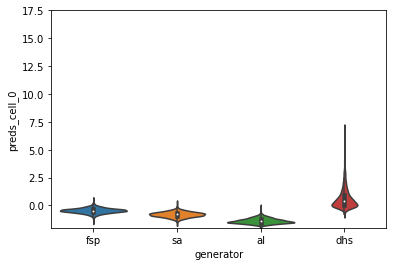

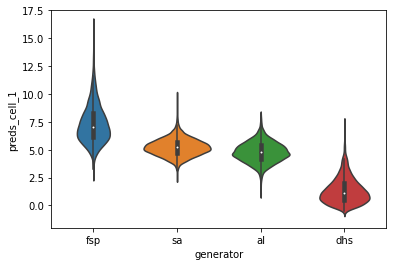

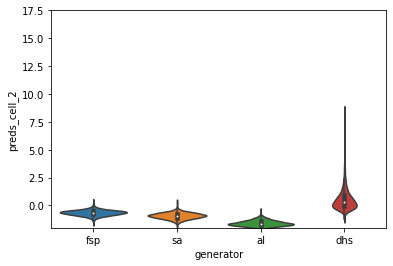

In [56]:
sns.violinplot( 
    data=all_data[ (all_data['penalty_round'] == 0) & (all_data['cell'] == 'hepg2') ],
    x='generator',
    y='preds_cell_0'
)
plt.ylim(-2, 17.5)
plt.show()

sns.violinplot( 
    data=all_data[ (all_data['penalty_round'] == 0) & (all_data['cell'] == 'hepg2') ],
    x='generator',
    y='preds_cell_1'
)
plt.ylim(-2, 17.5)
plt.show()

sns.violinplot( 
    data=all_data[ (all_data['penalty_round'] == 0) & (all_data['cell'] == 'hepg2') ],
    x='generator',
    y='preds_cell_2'
)
plt.ylim(-2, 17.5)
plt.show()

In [ ]:
pentamer_scan = boda.common.utils.KmerFilter(k=5)
kmer_content  = pentamer_scan( best_seqs[sample_energy.min(0).values <= 0.2] ).max(dim=-1).values

In [ ]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

In [ ]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)